# Consensus Aggregation SHAP Networks

This notebook implements consensus-based aggregation of SHAP values, focusing on robust, consistent effects across the population.

**Approach:** Only aggregate SHAP values where a majority of patients (≥70%) agree on the direction of effect. This filters out noisy, inconsistent features and highlights robust relationships.

In [1]:
import os
import sys
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cgt_perezsechi.visualization.graph import draw
from cgt_perezsechi.manipulation.norm import normalize_psi, normalize_r

c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configure matplotlib for VS Code Jupyter
%matplotlib inline

In [3]:
# Load data
X = pd.read_pickle("../data/x_values.pkl")
num_patients = 500
X_shapley = X.iloc[:num_patients, :]
shap_values = np.load("../data/shap_values.npy")
shap_interaction_values = np.load("../data/shap_interaction_values.npy")

## Consensus Parameters

In [4]:
# Consensus threshold: proportion of patients that must agree on direction
CONSENSUS_THRESHOLD = 0.70  # 70% must agree

# Minimum absolute SHAP value to consider (avoid counting near-zero values)
MIN_SHAP_THRESHOLD = 1e-5

print(f"Consensus threshold: {CONSENSUS_THRESHOLD*100}%")
print(f"Minimum SHAP threshold: {MIN_SHAP_THRESHOLD}")

Consensus threshold: 70.0%
Minimum SHAP threshold: 1e-05


## Build Consensus SHAP Values (psi_1)

In [5]:
shap_values_clean = np.nan_to_num(shap_values)

# For each feature, check consensus
consensus_shap_values = np.zeros_like(shap_values_clean)
n_features = shap_values_clean.shape[1]

consensus_stats = []

for feature_idx in range(n_features):
    feature_shap = shap_values_clean[:, feature_idx]
    
    # Count patients with significant positive/negative effects
    significant_mask = np.abs(feature_shap) > MIN_SHAP_THRESHOLD
    n_significant = significant_mask.sum()
    
    if n_significant == 0:
        continue
    
    n_positive = (feature_shap[significant_mask] > 0).sum()
    n_negative = (feature_shap[significant_mask] < 0).sum()
    
    positive_prop = n_positive / n_significant
    negative_prop = n_negative / n_significant
    
    # Check if consensus is reached
    if positive_prop >= CONSENSUS_THRESHOLD:
        # Keep only positive values
        consensus_shap_values[:, feature_idx] = np.where(
            feature_shap > 0, feature_shap, 0
        )
        consensus_stats.append({
            'feature': X_shapley.columns[feature_idx],
            'direction': 'positive',
            'consensus': positive_prop,
            'n_agree': n_positive
        })
    elif negative_prop >= CONSENSUS_THRESHOLD:
        # Keep only negative values
        consensus_shap_values[:, feature_idx] = np.where(
            feature_shap < 0, feature_shap, 0
        )
        consensus_stats.append({
            'feature': X_shapley.columns[feature_idx],
            'direction': 'negative',
            'consensus': negative_prop,
            'n_agree': n_negative
        })
    # If no consensus, values remain zero

# Build psi_1
sum_shap_values = np.sum(np.abs(consensus_shap_values), axis=(0, 1))
psi_1 = pd.DataFrame()
psi_1['value'] = np.sum(consensus_shap_values, axis=0) / sum_shap_values
psi_1.set_index(X_shapley.columns, inplace=True)

print(f"\nFeatures with consensus: {len(consensus_stats)} / {n_features}")
consensus_df = pd.DataFrame(consensus_stats)
if len(consensus_df) > 0:
    print(f"\nConsensus features:\n{consensus_df.sort_values('consensus', ascending=False)}")


Features with consensus: 54 / 80

Consensus features:
                                    feature direction  consensus  n_agree
8                         BUN_isTestnotdone  negative   1.000000       27
14                 potassium_isUnacceptable  negative   1.000000      239
12                creatinine_isUnacceptable  positive   1.000000      323
9                    calcium_isUnacceptable  negative   1.000000      500
7                        BUN_isUnacceptable  negative   1.000000      500
26                    platelets_isIncreased  negative   1.000000      500
44                    urine_glucose_isTrace  negative   1.000000      500
43                 urine_glucose_isVerydark  negative   1.000000      500
52                 uric_acid_isUnacceptable  positive   1.000000      500
35                    urine_albumin_is>=100  negative   1.000000      500
32                    cholesterol_isMissing  positive   1.000000        7
37                   urine_albumin_is>=1000  negative   1

## Build Consensus Interaction Values (r_1)

In [6]:
# Remove diagonal
n_variables = shap_interaction_values.shape[1]
filtered_shap_interaction_values = np.nan_to_num(shap_interaction_values.copy())
idx_patients = np.repeat(np.arange(num_patients), n_variables)
idx_variables = np.tile(np.arange(n_variables), num_patients)
filtered_shap_interaction_values[idx_patients, idx_variables, idx_variables] = 0

# Build consensus interaction matrix
consensus_interaction_values = np.zeros_like(filtered_shap_interaction_values)

consensus_interaction_stats = []

for i in range(n_variables):
    for j in range(n_variables):
        if i == j:
            continue
        
        interaction = filtered_shap_interaction_values[:, i, j]
        
        # Count patients with significant positive/negative interactions
        significant_mask = np.abs(interaction) > MIN_SHAP_THRESHOLD
        n_significant = significant_mask.sum()
        
        if n_significant == 0:
            continue
        
        n_positive = (interaction[significant_mask] > 0).sum()
        n_negative = (interaction[significant_mask] < 0).sum()
        
        positive_prop = n_positive / n_significant
        negative_prop = n_negative / n_significant
        
        # Check consensus
        if positive_prop >= CONSENSUS_THRESHOLD:
            consensus_interaction_values[:, i, j] = np.where(
                interaction > 0, interaction, 0
            )
            consensus_interaction_stats.append({
                'feature_i': X_shapley.columns[i],
                'feature_j': X_shapley.columns[j],
                'direction': 'positive',
                'consensus': positive_prop
            })
        elif negative_prop >= CONSENSUS_THRESHOLD:
            consensus_interaction_values[:, i, j] = np.where(
                interaction < 0, interaction, 0
            )
            consensus_interaction_stats.append({
                'feature_i': X_shapley.columns[i],
                'feature_j': X_shapley.columns[j],
                'direction': 'negative',
                'consensus': negative_prop
            })

# Build r_1
sum_shap_interaction_values = np.sum(consensus_interaction_values, axis=(0, 1, 2))
cumulative_shap_interaction_values = np.sum(consensus_interaction_values, axis=0)

r_1 = pd.DataFrame(cumulative_shap_interaction_values / sum_shap_interaction_values)
r_1.rename(columns=dict(list(zip(r_1.columns, X_shapley.columns))), inplace=True)
r_1.set_index(X_shapley.columns, inplace=True)

print(f"\nInteractions with consensus: {len(consensus_interaction_stats)} / {n_variables*(n_variables-1)}")


Interactions with consensus: 1107 / 6320


## Normalize Matrices

In [7]:
psi_2 = normalize_psi(psi_1)
r_2 = normalize_r(r_1)

c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\cgt_perezsechi\manipulation\norm.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_edge_width = r.applymap(lambda x: abs(x)).max().max()
c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\cgt_perezsechi\manipulation\norm.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  r = r.copy().applymap(lambda x: x / max_edge_width)


## Visualization

In [15]:
shap_cmap = shap.plots.colors.red_blue
positive_color = shap_cmap(0.0)[:3]
negative_color = shap_cmap(1.0)[:3]

positive_alpha = 0.2
negative_alpha = 0.2
positive_beta = 0
negative_beta = 0

c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\cgt_perezsechi\visualization\graph.py:53: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  r = r.copy().applymap(filter_edge)
c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\cgt_perezsechi\visualization\graph.py:54: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  adjacency = r.copy().applymap(lambda x: 1 if x != 0 else 0)


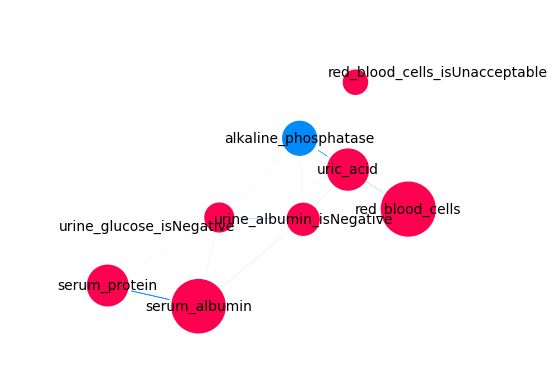

In [16]:
draw(
    psi=psi_2,
    r=r_2,
    positive_alpha=positive_alpha,
    negative_alpha=negative_alpha,
    positive_beta=positive_beta,
    negative_beta=negative_beta,
    negative_color=negative_color,
    positive_color=positive_color,
    label_color='black',
    label_weight='normal',
    plot_margin=0.25
)

## Top Consensus Features

In [17]:
print("Top 15 Consensus Features:")
top_features = psi_1['value'].abs().nlargest(15)
print(top_features)

Top 15 Consensus Features:
red_blood_cells                   1.000000
serum_albumin                     0.978308
uric_acid                         0.579316
serum_protein                     0.566293
alkaline_phosphatase              0.394967
urine_albumin_isNegative          0.350801
urine_glucose_isNegative          0.285923
red_blood_cells_isUnacceptable    0.201442
SGOT                              0.182432
potassium                         0.165965
urine_glucose_isDark              0.132372
total_bilirubin                   0.098937
BUN                               0.097084
urine_albumin_is>=100             0.089923
sodium                            0.067901
Name: value, dtype: float64


## Sensitivity Analysis - Different Consensus Thresholds

In [18]:
# Compare number of features meeting different consensus thresholds
thresholds = [0.50, 0.60, 0.70, 0.80, 0.90]
threshold_results = []

for threshold in thresholds:
    count = 0
    for feature_idx in range(n_features):
        feature_shap = shap_values_clean[:, feature_idx]
        significant_mask = np.abs(feature_shap) > MIN_SHAP_THRESHOLD
        n_significant = significant_mask.sum()
        
        if n_significant == 0:
            continue
        
        n_positive = (feature_shap[significant_mask] > 0).sum()
        n_negative = (feature_shap[significant_mask] < 0).sum()
        
        positive_prop = n_positive / n_significant
        negative_prop = n_negative / n_significant
        
        if positive_prop >= threshold or negative_prop >= threshold:
            count += 1
    
    threshold_results.append({
        'threshold': threshold,
        'n_features': count,
        'proportion': count / n_features
    })

sensitivity_df = pd.DataFrame(threshold_results)
print("\nConsensus Threshold Sensitivity:")
print(sensitivity_df)


Consensus Threshold Sensitivity:
   threshold  n_features  proportion
0        0.5          74      0.9250
1        0.6          65      0.8125
2        0.7          54      0.6750
3        0.8          46      0.5750
4        0.9          35      0.4375
